# MinPy (MXNet NumPy)

*"Everybody loves NumPy."*

In this tutorial, we present MinPy -- a NumPy-like package based on MXNet. NumPy is a well-known python package widely used in scientific computing, statistics and machine learning. It supports a wide range of tensor operators and is very friendly to machine learning beginners. Here, we will walk with you through a simple example of *logistic regression* using NumPy. After that we will illustrate how MinPy utilizes GPUs to speed up your machine learning algorithm with few (or no) changes in your original NumPy code. We hope by following this direction, we could solve the ultimate trade-off that every machine learning tools are facing with: *how to achieve both efficiency and flexibility?*

In [1]:
# A bit of setup, just ignore this cell.
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt

# For auto-reloading external modules.
%load_ext autoreload
%autoreload 2

%matplotlib inline
# Set default size of plots.
plt.rcParams['figure.figsize'] = (8.0, 6.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

*Before start:* MinPy is still a work in progress, so you may encounter problems when playing with it. You could always try *Kernel->Restart & Clear Output* and go through the tutorial again.

## Multinomial Logistic Regression using NumPy

Logistic regression is a supervised machine learning algorithm that is commonly used in classification. The *supervised* word here means each data sample (represented by a float vector) is *labeled*. We have provided some util functions to fetch some generated data for you.

In [2]:
import numpy as np
import numpy.random as random
import time
from util import get_data, plot_data

# Initialize training data.
data, label = get_data()
num_samples = data.shape[0]
num_features = data.shape[1]
num_classes = label.shape[1]

print('Shapes: data {}, label {}'.format(data.shape, label.shape))
print('#samples: {}'.format(num_samples))
print('#features: {}'.format(num_features))
print('#classes: {}'.format(num_classes))

Shapes: data (10000, 500), label (10000, 5)
#samples: 10000
#features: 500
#classes: 5


In our example, the training data contains 10000 samples. Each sample has 500 features, so the training samples could be represented by a 10000 x 500 matrix. Our goal is to classify each sample into 5 classes. Therefore, each sample comes with a label which is encoded in *one-of-many* format. For example, say sample 0 is of class 1, then the corresponding label vector for sample 0 will be `[0, 1, 0, 0, 0]`. Therefore, label could be represented by a 10000 x 5 matrix as follows:

In [3]:
print('Data matrix:')
print(data)
print()
print('Label matrix:')
print(label)

Data matrix:
[[ 0.32734496  0.38202421  0.88363333 ...,  0.56855788  0.77482872
   0.78661045]
 [ 0.30944119  0.31369851  0.7323332  ...,  0.52735346  0.54504115
   0.86898225]
 [ 0.37802308  0.43419765  0.66645294 ...,  0.64980071  0.55614532
   0.76352769]
 ..., 
 [ 0.23139488  0.46588139  0.54704782 ...,  0.8856756   0.07421766
   0.61662582]
 [ 0.00828138  0.17924487  0.53160273 ...,  1.05838437  0.1968327
   0.63039901]
 [ 0.05748305  0.27938298  0.46694946 ...,  0.82950457  0.06558127
   0.6286073 ]]

Label matrix:
[[ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 ..., 
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]]


We provide a function `plot_data` for you to visualize what the data looks like. It projects each 500-D samples onto their first two dimensions, so each sample is a point in the figure. We distinguish samples of different classes using different colors. Although this is a very simple example, the idea behind is similar to more complicated examples you will encounter in the following tutorials. For example, if this is an *Optical Character Recognition (OCR)* task (like the MNIST example we are going to talk about), you could think about the blue points are the samples of digit 0 and red points are digit 1. Then our goal is to correctly classify some *unknown* samples (test data) into the most likely classes.

Ground truth:


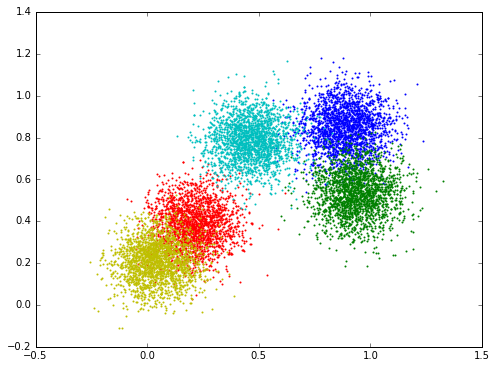

In [4]:
# Visualize what the ground truth data looks like.
print('Ground truth:')
plot_data(data, label)

The model we are using here is called *Multinomial Logistic Regression*, or called *Softmax Regression*. Original logistic regression could only deal with binary classes (either 0 or 1) while multinomial logistic regression allows you to classify samples into multiple classes. The model contains a weight matrix `w` that projects from feature space to class space (so its dimension is $\#feature \times \#class$). It first calculate the probability of each class given the samples:
$$p(y^{(i)}=j \mid x^{(i)};w)= \frac{\exp(w_j^Tx^{(i)})}{\sum_k\exp(w_k^Tx^{(i)})}.$$
Try implement the following `predict` function that corresponds to the above math equation.

In [5]:
# Predict the class using logistic regression.
def predict(w, x):
    #===========================================================#
    #                    Your code starts here                  #
    #===========================================================#
    # Please try compute the estimated probability of each sample.
    a = np.exp(np.dot(x, w))
    a_sum = np.sum(a, axis=1, keepdims=True)
    prob = a / a_sum
    #===========================================================#
    #                    Your code ends here                    #
    #===========================================================#
    return prob

We could then use the above `predict` function to see what a random guess may look like. We first initialize the `weight` matrix using random numbers. Then feed the predict result into the `plot_data` function for visualization. You could see that, the random guess is completely different than the correct labels.

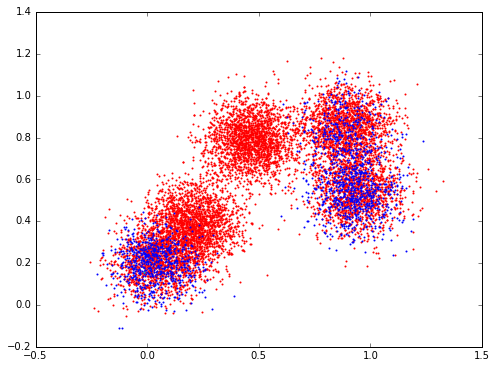

In [6]:
# Initialize training weight.
weight = random.randn(num_features, num_classes)

# Visualize the initial guess.
plot_data(data, predict(weight, data))

Multinomial logistic regression then tries to minimize the *cross entropy* between the `predict` class probability and the correct probability. More specifically, it tries to minimize the following equation:
$$J(w)=-\frac{1}{m}\left[\sum_{i=1}^{m}\sum_{j=1}^{k}1\{y^{(i)}=j\}\log (p(y^{(i)}=j \mid x^{(i)};w))\right],$$
where $m$ is the number of samples, $1\{\dots\}$ is the indicator function which equals to 1 if the condition holds, otherwise equals to 0.

Try implement the loss calculation in the following code. Note that our label (the correct probability) has already been transformed into *one-of-many* form, so the indicator function here is simply an element-wise multiplication of the label matrix and the logarithmic probability.

To minimize this function, we use a method called **batch gradient descent**. It first calculates the gradient of the weight matrix as follows:
$$\nabla_{w}J(w)=-\frac{1}{m}\sum_{i=1}^{m}\left[x^{(i)}(1\{y^{(i)}=j\}-p(y^{(i)}=j \mid x^{(i)};w))\right],$$
then update the current model along the gradient direction:
$$w\leftarrow w - \alpha \nabla_{w}J(w).$$
We have implemented the gradient computation and the weight update for you.

In [7]:
# Using gradient descent to fit the correct classes.
def train(w, x, loops):
    for i in range(loops):
        prob = predict(w, x)
        if i % 10 == 0:
            #===========================================================#
            #                    Your code starts here                  #
            #===========================================================#
            # Please try compute the current loss value.
            loss = -np.sum(label * np.log(prob)) / num_samples
            #===========================================================#
            #                    Your code ends here                    #
            #===========================================================#
            print('Iter {}, training loss {}'.format(i, loss))
        # Calculate gradient of weight.
        dy = prob - label
        dw = np.dot(data.T, dy) / num_samples
        # Update.
        w -= 0.1 * dw

Once you have finished the above codes, you could now try to optimize it for 100 iterations. You should see the loss value dropping.

In [8]:
# Now training it for 100 iterations.
start_time = time.time()
train(weight, data, 100)
print('Training time: {}s'.format(time.time() - start_time))

Iter 0, training loss 13.7924990127
Iter 10, training loss 1.06352076609
Iter 20, training loss 0.218664996845
Iter 30, training loss 0.104567019729
Iter 40, training loss 0.0659555569891
Iter 50, training loss 0.0473030933699
Iter 60, training loss 0.0365131342255
Iter 70, training loss 0.0295508679103
Iter 80, training loss 0.0247169548113
Iter 90, training loss 0.021179940258
Training time: 3.00638508797s


Now you could visualize the prediction with trained model again. It should now be very close to what the ground truth is.

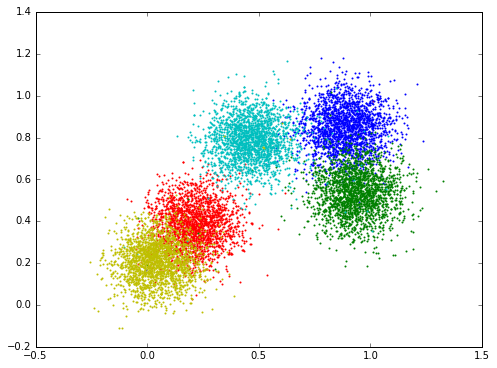

In [9]:
# Plot the prediction after training. It should show similar image as the ground truth.
plot_data(data, predict(weight, data))

## Multinomial Logistic Regression using MinPy (MXNet NumPy)

### Utilize GPU computation with little (or no) NumPy syntax change

You could see even with such a tiny example, 100 iterations take around 9 seconds. In real world, there are billions of samples and much more features and classes. How to efficiently train such a model? One solution is to use GPU. Our tool, MinPy allows you to use GPU to speed up the algorithm and in the meantime, keep the neat NumPy syntax you just went through.

In [ ]:
# All you need to do is replace the NumPy namespace with MinPy's.
import minpy.numpy as np
import minpy.numpy.random as random

In [ ]:
# Initialize weight matrix (again).
weight = random.randn(num_features, num_classes)

# Now call the same training function.
# Since the namespace is redefined, it will automatically run on GPU.
start_time = time.time()
train(weight, data, 100)
 # You should observe a significant speed up (around 3x) to the previous training time.
print('Training time: {}s'.format(time.time() - start_time))

### Automatic gradient calculation

Compute gradient is tedious especially for complex neural networks you will encounter in the following tutorials. Minpy is able to compute the gradient automatically given arbitrary loss function. Please implement the following loss function (or paste it from your previous codes). The `grad_and_loss` function takes your defined `train_loss` function and then returns a function which will calculate both the loss value and the gradient of weight. The gradient could then be directly used to update the model weight.

**Quiz:** Try modify the loss function by adding an L2-regularization. The new loss function is as follows:
$$J'(w)=J(w)+\sum_{i}w_i^2.$$

In [ ]:
from minpy.core import grad_and_loss

# Initialize weight matrix (again).
weight = random.randn(num_features, num_classes)

# Using gradient descent to fit the correct classes.
def train_loss(w, x):
    #===========================================================#
    #                    Your code starts here                  #
    #===========================================================#
    prob = predict(w, x)
    loss = -np.sum(label * np.log(prob)) / num_samples + np.sum(w * w)
    #===========================================================#
    #                    Your code ends here                    #
    #===========================================================#
    return loss

# Calculate gradient function automatically.
grad_function = grad_and_loss(train_loss)

# Now training it for 100 iterations.
start_time = time.time()
for i in range(100):
    dw, loss = grad_function(weight, data)
    if i % 10 == 0:
        print('Iter {}, training loss {}'.format(i, loss))
    weight -= 0.1 * dw
print('Training time: {}s'.format(time.time() - start_time))

In [ ]:
# Plot the result.
# ATTENTION: When calling an external package implemented by NumPy, you need to explicitly convert MinPy's array to NumPy's array.
plot_data(data, predict(weight, data).asnumpy())

### Graceful fallback when GPU operators are missing

NumPy is a giant library with hundreds of operators. Our supported GPU operators are only a subset of them, so it is inevitable that you want to try some functions that are currently missing on GPU side. To solve this problem, MinPy gracefully adopts the NumPy implementation once the operator is missing on GPU side, and handles the memory copies among GPU and CPU for you.

In [ ]:
# First turn on the logging to know what happens under the hood.
import logging
logging.getLogger('minpy.array').setLevel(logging.DEBUG)

x = np.zeros((10, 20))

# `cosh` is currently missing in MXNet's GPU implementation.
# So it will fallback to use NumPy's CPU implementation,
# but you don't need to worry about the memory copy from GPU -> CPU
y = np.cosh(x)

# `log` has GPU implementation, so it will copy the array from CPU -> GPU.
# Once again, you don't need to worry about it. It is transparent.
z = np.log(y)

# Turn off the logging.
logging.getLogger('minpy.array').setLevel(logging.WARN)

### Use predefined MXNet symbol as one operator

Now we solve the problem of missing GPU operators. What if we want to use some efficient special operators for neural network that only have GPU implementation? For example, convolution is very slow in numpy's implementation, while NVIDIA provides very efficient CUDA implementation. Hence, MinPy allows you to directly use MXNet's symbol as one operator, and you could mix MXNet's declarative programming with Minpy's imperative programming in one piece of code. The following example replaces the computation of:
$$p(y^{(i)}=j \mid x^{(i)};w)= \frac{\exp(w_j^Tx^{(i)})}{\sum_j\exp(w_j^Tx^{(i)})}$$
 with a predefined `SoftmaxOutput` symbol.

**Quiz: ** After you have gone through the next tutorial about MNIST OCR task. You could try replace the `np.dot` function with the `sym.FullyConnected` symbol. Remember, you could combine multiple symbols into one operator.

In [ ]:
import mxnet
import mxnet.symbol as sym
from minpy.core import function

# Define softmax symbol (this part will be covered in the later tutorial).
x_shape = (num_samples, num_classes)
label_shape = (num_samples,)
softmax_symbol = sym.SoftmaxOutput(data=sym.Variable('x'), name='softmax', grad_scale=1.0/num_samples)

# Convert MXNet symbol into a callable function (with corresponding gradient function).
softmax = function(softmax_symbol, [('x', x_shape), ('softmax_label', label_shape)])

# Make `softmax_label`. MXNet's softmax operator does not use one-of-many label format.
softmax_label = np.argmax(label, axis=1)

# Redefine loss function using softmax as one operator.
def train_loss(w, x):
    y = np.dot(x, w)
    prob = softmax(x=y, softmax_label=softmax_label)
    loss = -np.sum(label * np.log(prob)) / num_samples
    return loss

# Initialize weight matrix (again).
weight = random.randn(num_features, num_classes)

# Calculate gradient function automatically.
grad_function = grad_and_loss(train_loss)

# Now training it for 100 iterations.
start_time = time.time()
for i in range(100):
    dw, loss = grad_function(weight, data)
    if i % 10 == 0:
        print('Iter {}, training loss {}'.format(i, loss))
    weight -= 0.1 * dw
print('Training time: {}s'.format(time.time() - start_time))